# Caso: Modelo de Predicción de Venta cruzada de seguros

Puede descargar los datos de: https://www.kaggle.com/competitions/playground-series-s4e7/data

## Instalar las librerías

In [1]:
!pip install catboost
!pip install polars
!pip install ydata-profiling
!pip install kds

## 1. Carga de Módulos

In [2]:
import warnings
warnings.simplefilter('ignore')

from catboost import CatBoostClassifier, Pool
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, classification_report, roc_auc_score, f1_score, auc
)
import kds
import polars as pl

%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

In [6]:
test.columns

['id',
 'Gender',
 'Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage']

## 2. Lectura Inicial de base de datos

### 2.1 Carga de datos

In [7]:
import polars as pl

# Leer data original
train = pl.read_csv('../data/raw/train.csv')
test = pl.read_csv('../data/raw/test.csv')

# Filtrar solo las filas donde Response no es nulo
train_no_null = train.filter(pl.col("Response").is_not_null())

# Tomar 1 millón de filas aleatorias solo de las filas válidas
train_1M = train_no_null.sample(n=1_000_000, shuffle=True, seed=42)

test_1M = test.sample(n=1_000_000, shuffle=True, seed=42)

# Guardar como nuevos archivos
train_1M.write_csv('../data/raw/train.csv')
test_1M.write_csv('../data/raw/test.csv')

print(train_1M.shape, test_1M.shape)

(1000000, 12) (1000000, 11)


In [8]:
# Leemos la data de entrenamiento y test
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

In [9]:
# Concatenamos para tener único dataframe
df = pd.concat([train])

In [10]:
# Vemos la dimensionalidad
df.shape

(1000000, 12)

In [11]:
# Visualizacion Global de los datos
df.head()

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   9368416    Male   22                1         28.0                   1   
1   3667972  Female   40                1         28.0                   0   
2  11319503    Male   54                1         18.0                   1   
3   8066424    Male   37                1         28.0                   0   
4   9129109    Male   26                1         11.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0    < 1 Year             No         34337.0                 152.0      211   
1    1-2 Year            Yes         34918.0                 124.0      238   
2    1-2 Year            Yes         47299.0                  26.0      166   
3    1-2 Year            Yes         38399.0                  26.0      165   
4    < 1 Year             No         25759.0                 152.0       80   

   Response  
0         0  
1         0  
2         0  
3         1  
4         0

### 2.2. Buenas prácticas

In [12]:
df.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 12 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1000000 non-null  int64  
 1   Gender                1000000 non-null  object 
 2   Age                   1000000 non-null  int64  
 3   Driving_License       1000000 non-null  int64  
 4   Region_Code           1000000 non-null  float64
 5   Previously_Insured    1000000 non-null  int64  
 6   Vehicle_Age           1000000 non-null  object 
 7   Vehicle_Damage        1000000 non-null  object 
 8   Annual_Premium        1000000 non-null  float64
 9   Policy_Sales_Channel  1000000 non-null  float64
 10  Vintage               1000000 non-null  int64  
 11  Response              1000000 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 91.6+ MB


# 3. AED

## 3.1. Completitud de los datos

In [14]:
# Revisamos los valores nulos o missings
df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

## 3.2. Análisis Univariado

In [15]:
profile = ProfileReport(df, title="Reporte Pandas Profiling")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.21it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

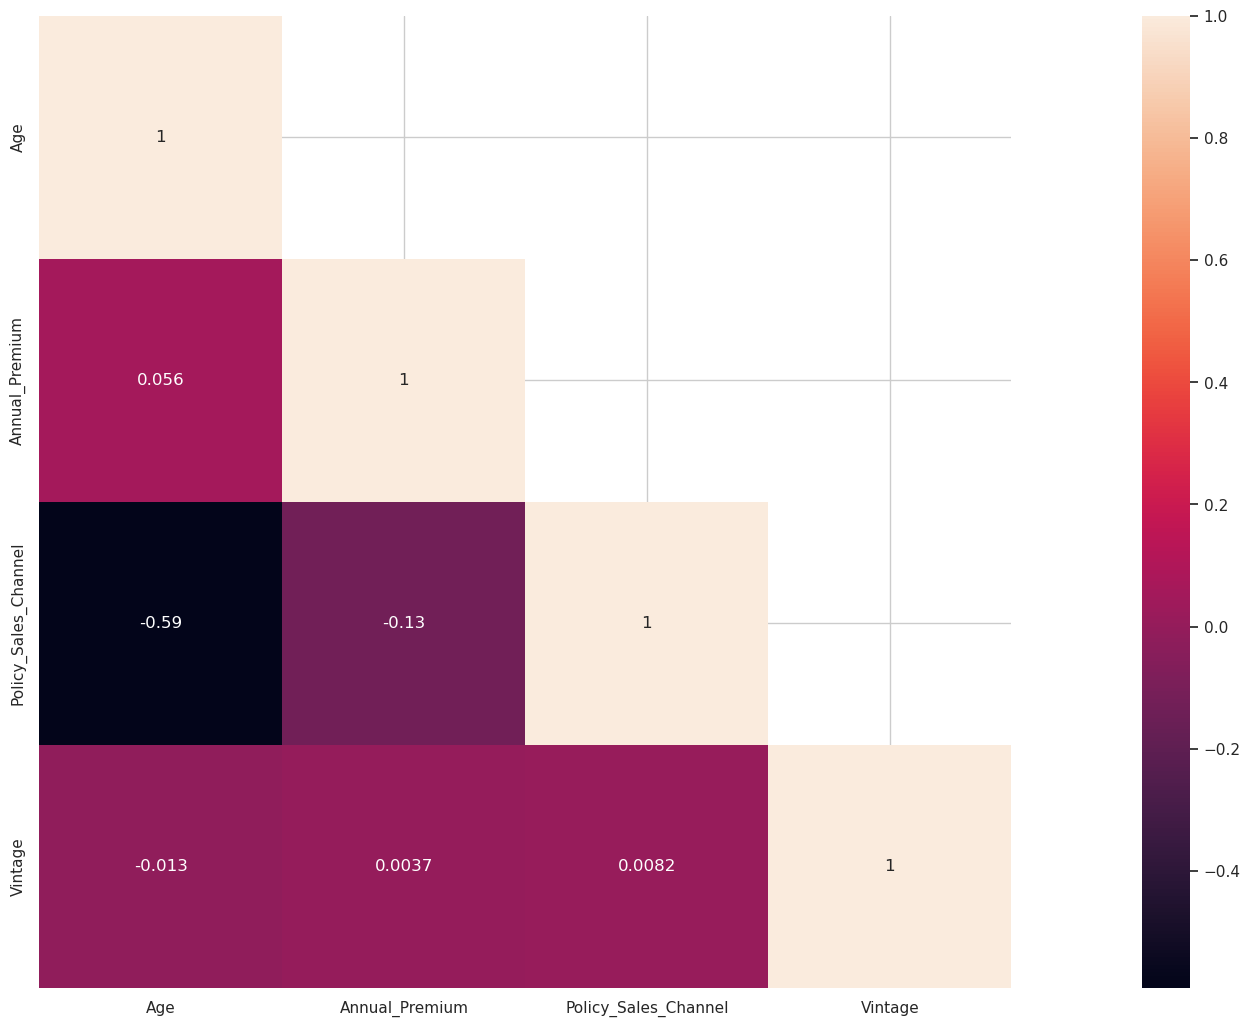

In [16]:
# Matriz de corelaciones
cor_mat = df[['Age', 'Annual_Premium','Policy_Sales_Channel', 'Vintage']].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)
plt.show()

## 3.3. Recodificación y transformación de los datos

In [17]:
# Recodificamos variables 
df["Gender"] = df["Gender"].replace({"Male": 0, "Female": 1}).astype("int32")
df["Region_Code"] = df["Region_Code"].astype(int)
df["Vehicle_Age"] = df["Vehicle_Age"].replace({"< 1 Year": 0, "1-2 Year": 1, "> 2 Years": 2}).astype("int32")
df["Vehicle_Damage"] = df["Vehicle_Damage"].replace({"No": 0, "Yes": 1}).astype("int32")
df["Annual_Premium"] = df["Annual_Premium"].astype(int)
df["Policy_Sales_Channel"] = df["Policy_Sales_Channel"].astype(int)

# 4. Ingeniería y Selección de Variables

## 4.1. Ingeniería de variables

In [18]:
# Transformamos variables
df["Previously_Insured_Annual_Premium"] = pd.factorize(
    df["Previously_Insured"].astype(str) + df["Annual_Premium"].astype(str)
)[0]

df["Previously_Insured_Vehicle_Age"] = pd.factorize(
    df["Previously_Insured"].astype(str) + df["Vehicle_Age"].astype(str)
)[0]

df["Previously_Insured_Vehicle_Damage"] = pd.factorize(
    df["Previously_Insured"].astype(str) + df["Vehicle_Damage"].astype(str)
)[0]

df["Previously_Insured_Vintage"] = pd.factorize(
    df["Previously_Insured"].astype(str) + df["Vintage"].astype(str)
)[0]

In [19]:
df.to_csv("../data/processed/insurance_val.csv")

# 5. Modelamiento de Datos o Creación del Algoritmo de ML

## 5.1. Partición Muestral

In [20]:
data = df.sample(frac=0.9, random_state=1000)
data_unseen = df.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

# Creación de los datos de train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Response'],axis=1),
                                                   df.Response,
                                                   test_size=0.333,
                                                   random_state=12345)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Data for Modeling: (900000, 16)
Unseen Data For Predictions: (100000, 16)
(667000, 15) (667000,)
(333000, 15) (333000,)


In [21]:
X_train.head()

id  Gender  Age  Driving_License  Region_Code  \
860952  8087341       1   23                1           37   
536555  5270074       1   39                1            8   
368636   163872       1   36                1           28   
344244  2787313       1   22                1           29   
747155  5655861       0   24                1            3   

        Previously_Insured  Vehicle_Age  Vehicle_Damage  Annual_Premium  \
860952                   1            0               0           32409   
536555                   0            1               1           30582   
368636                   0            1               1           37907   
344244                   1            0               0           38346   
747155                   1            0               0           30897   

        Policy_Sales_Channel  Vintage  Previously_Insured_Annual_Premium  \
860952                   152      250                               1686   
536555                    26       24                              11814   
368636                   154      240                              13561   
344244                   152      176                              35943   
747155                   152      201                                226   

        Previously_Insured_Vehicle_Age  Previously_Insured_Vehicle_Damage  \
860952                               0                                  0   
536555                               1                                  1   
368636                               1                                  1   
344244                               0                                  0   
747155                               0                                  0   

        Previously_Insured_Vintage  
860952                          78  
536555                         390  
368636                         522  
344244                         292  
747155                         261

## 5.2. Algoritmos de Machine Learning

### Regresión Logística Binaria

In [22]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [23]:
lr.fit(X_train,y_train) # Entrenamiento!

LogisticRegression()

In [24]:
y_pred_train=lr.predict(X_train) # Prediccion sobre train
y_pred_test = lr.predict(X_test) # Prediccion sobre test

In [25]:
## Metricas de validación
def calc_metrics(y_train, y_pred_train, y_test, y_pred_test, show_train_report=False):

    # === MATRIZ DE CONFUSIÓN TRAIN ===
    print("=== Matriz de Confusión (Train) ===")
    cm_train = confusion_matrix(y_train, y_pred_train)
    print(cm_train)

    # === MATRIZ DE CONFUSIÓN TEST ===
    print("\n=== Matriz de Confusión (Test) ===")
    cm_test = confusion_matrix(y_test, y_pred_test)
    print(cm_test)

    # === CLASSIFICATION REPORT ===
    print("\n=== Classification Report (Test) ===")
    print(classification_report(y_test, y_pred_test))

    if show_train_report:
        print("\n=== Classification Report (Train) ===")
        print(classification_report(y_train, y_pred_train))

In [26]:
calc_metrics(y_train, y_pred_train, y_test, y_pred_test)

=== Matriz de Confusión (Train) ===
[[585162      0]
 [ 81838      0]]

=== Matriz de Confusión (Test) ===
[[292094      0]
 [ 40906      0]]

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    292094
           1       0.00      0.00      0.00     40906

    accuracy                           0.88    333000
   macro avg       0.44      0.50      0.47    333000
weighted avg       0.77      0.88      0.82    333000



In [27]:
ind = pd.DataFrame(columns = ['Modelo', 'F1Score'])

f1score=f1_score(y_test,y_pred_test)
ind = pd.concat(
    [ind, pd.DataFrame({'Modelo': ['LogReg'], 'F1Score': [f1score]})],
    ignore_index=True
)
ind

Modelo  F1Score
0  LogReg      0.0

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

decile  prob_min  prob_max  prob_avg  cnt_cust  cnt_resp  cnt_non_resp  \
0       1     0.219     0.445     0.269   33300.0    6339.0       26961.0   
1       2     0.172     0.219     0.192   33300.0    5785.0       27515.0   
2       3     0.148     0.172     0.159   33300.0    4761.0       28539.0   
3       4     0.131     0.148     0.139   33300.0    4386.0       28914.0   
4       5     0.116     0.131     0.124   33300.0    4198.0       29102.0   
5       6     0.101     0.116     0.109   33300.0    3668.0       29632.0   
6       7     0.087     0.101     0.094   33300.0    3480.0       29820.0   
7       8     0.075     0.087     0.081   33300.0    3049.0       30251.0   
8       9     0.063     0.075     0.069   33300.0    2979.0       30321.0   
9      10     0.030     0.063     0.055   33300.0    2261.0       31039.0   

   cnt_resp_rndm  cnt_resp_wiz  resp_rate  cum_cust  cum_resp  cum_resp_wiz  \
0         4090.6         33300     19.036   33300.0    6339.0         33300   
1         4090.6          7606     17.372   66600.0   12124.0         40906   
2         4090.6             0     14.297   99900.0   16885.0         40906   
3         4090.6             0     13.171  133200.0   21271.0         40906   
4         4090.6             0     12.607  166500.0   25469.0         40906   
5         4090.6             0     11.015  199800.0   29137.0         40906   
6         4090.6             0     10.450  233100.0   32617.0         40906   
7         4090.6             0      9.156  266400.0   35666.0         40906   
8         4090.6             0      8.946  299700.0   38645.0         40906   
9         4090.6             0      6.790  333000.0   40906.0         40906   

   cum_non_resp  cum_cust_pct  cum_resp_pct  cum_resp_pct_wiz  \
0       26961.0          10.0        15.497            81.406   
1       54476.0          20.0        29.639           100.000   
2       83015.0          30.0        41.278           100.000   
3      111929.0          40.0        52.000           100.000   
4      141031.0          50.0        62.262           100.000   
5      170663.0          60.0        71.229           100.000   
6      200483.0          70.0        79.736           100.000   
7      230734.0          80.0        87.190           100.000   
8      261055.0          90.0        94.473           100.000   
9      292094.0         100.0       100.000           100.000   

   cum_non_resp_pct      KS   lift  
0             9.230   6.267  1.550  
1            18.650  10.989  1.482  
2            28.421  12.857  1.376  
3            38.320  13.680  1.300  
4            48.283  13.979  1.245  
5            58.427  12.802  1.187  
6            68.636  11.100  1.139  
7            78.993   8.197  1.090  
8            89.374   5.099  1.050  
9           100.000   0.000  1.000

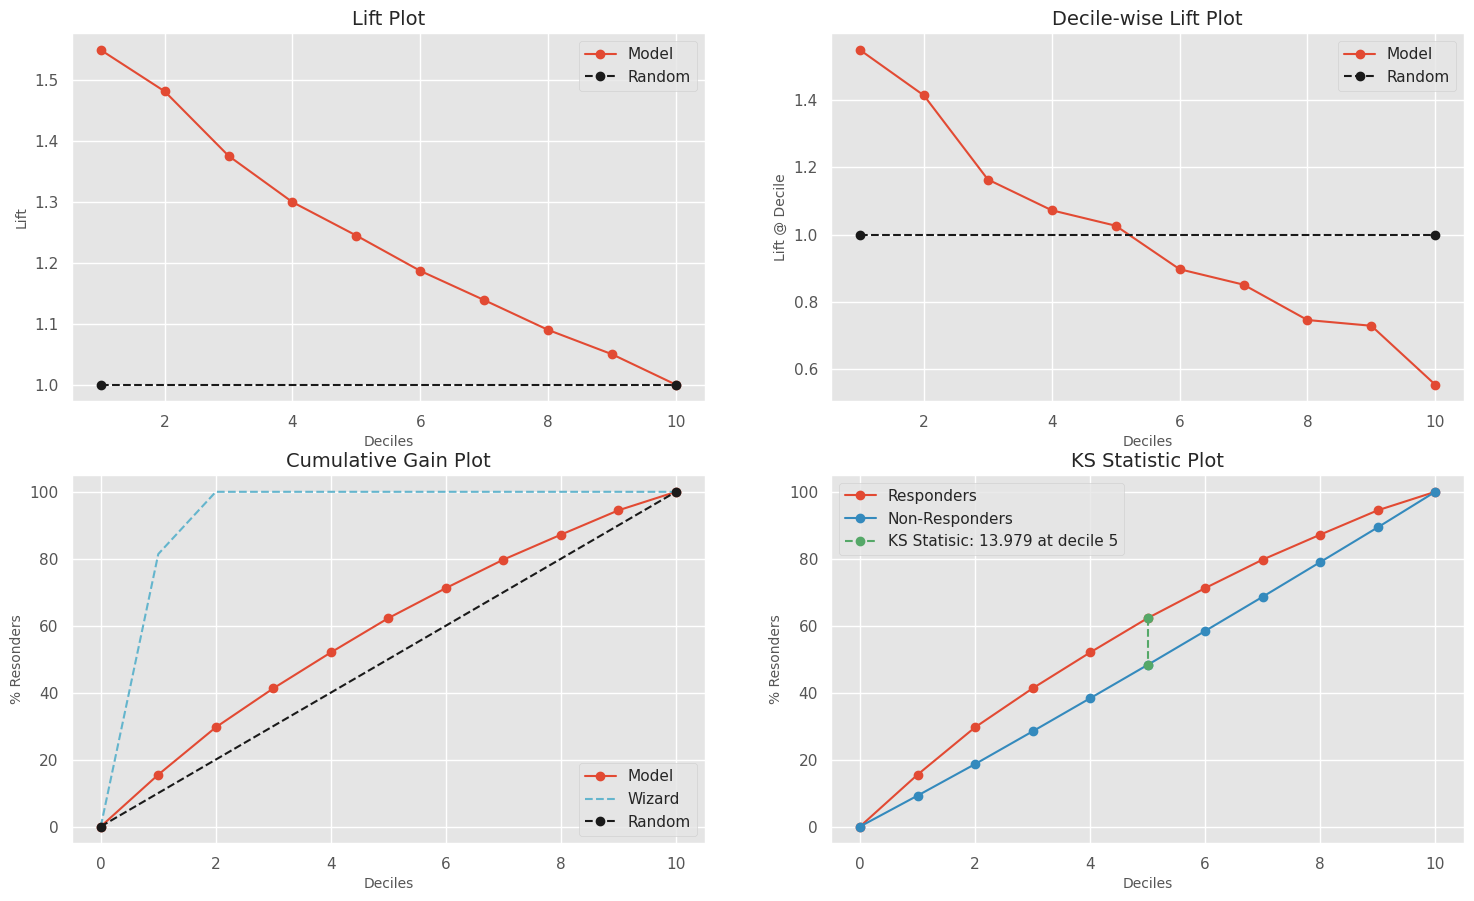

In [28]:
y_prob = lr.predict_proba(X_test)
kds.metrics.report(y_test, y_prob[:,1],plot_style='ggplot')

### Xgboost

In [30]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 1.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 571.5 kB/s eta 0:00:0000:0100:01


In [31]:
import xgboost as xgb
xgb_mod=xgb.XGBClassifier(max_depth=2, n_estimators=50, objective='binary:logistic', seed=0, silent=True, subsample=.8)
xgb_mod.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)

In [32]:
# Predecir con el algoritmo entrenado para validar
y_pred_train=xgb_mod.predict(X_train) # Prediccion sobre train
y_pred_test= xgb_mod.predict(X_test) # Prediccion sobre test

In [33]:
calc_metrics(y_train,y_pred_train,y_test,y_pred_test)

=== Matriz de Confusión (Train) ===
[[585115     47]
 [ 81777     61]]

=== Matriz de Confusión (Test) ===
[[292077     17]
 [ 40874     32]]

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    292094
           1       0.65      0.00      0.00     40906

    accuracy                           0.88    333000
   macro avg       0.77      0.50      0.47    333000
weighted avg       0.85      0.88      0.82    333000



In [34]:
f1score=f1_score(y_test,y_pred_test)
ind = pd.concat(
    [ind, pd.DataFrame({'Modelo': ['XGBoost'], 'F1Score': [f1score]})],
    ignore_index=True
)
ind

Modelo   F1Score
0   LogReg  0.000000
1  XGBoost  0.001563

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

decile  prob_min  prob_max  prob_avg  cnt_cust  cnt_resp  cnt_non_resp  \
0       1       0.0       1.0     0.001   33300.0    4088.0       29212.0   
1       2       0.0       0.0     0.000   33300.0    4026.0       29274.0   
2       3       0.0       0.0     0.000   33300.0    4125.0       29175.0   
3       4       0.0       0.0     0.000   33300.0    4078.0       29222.0   
4       5       0.0       0.0     0.000   33300.0    4069.0       29231.0   
5       6       0.0       0.0     0.000   33300.0    4086.0       29214.0   
6       7       0.0       0.0     0.000   33300.0    4067.0       29233.0   
7       8       0.0       0.0     0.000   33300.0    4190.0       29110.0   
8       9       0.0       0.0     0.000   33300.0    4079.0       29221.0   
9      10       0.0       0.0     0.000   33300.0    4098.0       29202.0   

   cnt_resp_rndm  cnt_resp_wiz  resp_rate  cum_cust  cum_resp  cum_resp_wiz  \
0         4090.6         33300     12.276   33300.0    4088.0         33300   
1         4090.6          7606     12.090   66600.0    8114.0         40906   
2         4090.6             0     12.387   99900.0   12239.0         40906   
3         4090.6             0     12.246  133200.0   16317.0         40906   
4         4090.6             0     12.219  166500.0   20386.0         40906   
5         4090.6             0     12.270  199800.0   24472.0         40906   
6         4090.6             0     12.213  233100.0   28539.0         40906   
7         4090.6             0     12.583  266400.0   32729.0         40906   
8         4090.6             0     12.249  299700.0   36808.0         40906   
9         4090.6             0     12.306  333000.0   40906.0         40906   

   cum_non_resp  cum_cust_pct  cum_resp_pct  cum_resp_pct_wiz  \
0       29212.0          10.0         9.994            81.406   
1       58486.0          20.0        19.836           100.000   
2       87661.0          30.0        29.920           100.000   
3      116883.0          40.0        39.889           100.000   
4      146114.0          50.0        49.836           100.000   
5      175328.0          60.0        59.825           100.000   
6      204561.0          70.0        69.767           100.000   
7      233671.0          80.0        80.010           100.000   
8      262892.0          90.0        89.982           100.000   
9      292094.0         100.0       100.000           100.000   

   cum_non_resp_pct     KS   lift  
0            10.001 -0.007  0.999  
1            20.023 -0.187  0.992  
2            30.011 -0.091  0.997  
3            40.016 -0.127  0.997  
4            50.023 -0.187  0.997  
5            60.025 -0.200  0.997  
6            70.033 -0.266  0.997  
7            79.999  0.011  1.000  
8            90.003 -0.021  1.000  
9           100.000  0.000  1.000

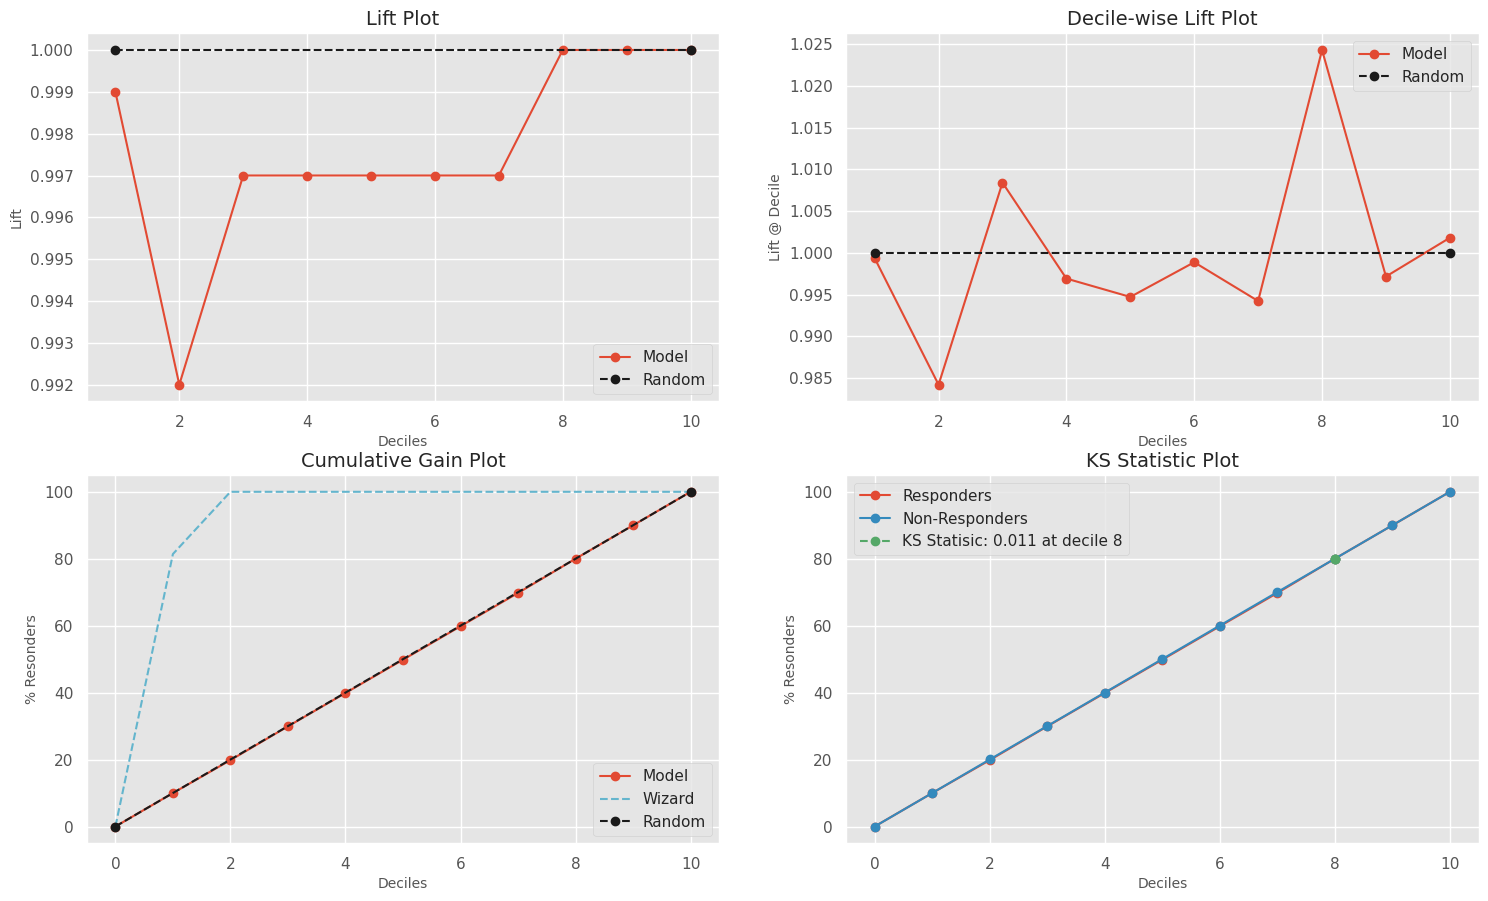

In [35]:
kds.metrics.report(y_test, y_pred_test,plot_style='ggplot')

### Grid Search de Parámetros

In [ ]:
# Definimos la funcion de GridSearch
from sklearn.model_selection import GridSearchCV         # Busqueda exhaustiva de la mejor combinacion
from sklearn.model_selection import RandomizedSearchCV   # Busqueda aleatoria de la mejor combinacion
from scipy.stats import randint as sp_randint

In [ ]:
# Configuramos el subset de parametros a trabajar
cv_params = {'max_depth': [2,3,4],
            'subsample':[0.7,0.8,0.9],
             'n_estimators':[50,100,200]}

In [ ]:
# Definimos un clasificador inicial, generalmente sin muchos parametros
xgboost_t=xgb.XGBClassifier().fit(X_train, y_train)

In [ ]:
# Con el clasificador inicial, tratamos de buscar los mejores parametros
optimized_GBM = RandomizedSearchCV(xgboost_t, cv_params, scoring = 'accuracy', cv = 5) 

In [ ]:
# Buscamos los parametros de acuerdo a nuestro criterio
opGBM=optimized_GBM.fit(X_train, y_train)

In [36]:
# De acuerdo a la busqueda , nos quedamos con los mejores parametros 
print (optimized_GBM.best_params_)

{'subsample': 0.9, 'n_estimators': 200, 'max_depth': 4}


In [38]:
# Predecimos con el algoritmo entrenado sobre el test y evaluamos
y_pred_train=opGBM.predict(X_train)
y_pred_test=opGBM.predict(X_test)

In [39]:
calc_metrics(y_train,y_pred_train,y_test,y_pred_test)

=== Matriz de Confusión (Train) ===
[[579223   5939]
 [ 72799   9039]]

=== Matriz de Confusión (Test) ===
[[288908   3186]
 [ 36631   4275]]

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.89      0.99      0.94    292094
           1       0.57      0.10      0.18     40906

    accuracy                           0.88    333000
   macro avg       0.73      0.55      0.56    333000
weighted avg       0.85      0.88      0.84    333000



In [ ]:
f1score=f1_score(y_test,y_pred_test)
ind = pd.concat(
    [ind, pd.DataFrame({'Modelo': ['GridSearch'], 'F1Score': [f1score]})],
    ignore_index=True
)
ind

In [54]:
y_prob_test = opGBM.predict_proba(X_test)[:, 1]

# Calcular curva precision-recall
prec, rec, thresholds = precision_recall_curve(y_test, y_prob_test)

# Evitar división por cero
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-9)

# Índice del mejor F1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print("Mejor threshold:", best_threshold)
print("F1 alcanzado:", best_f1)

Mejor threshold: 0.24525088
F1 alcanzado: 0.4839323586797571


In [55]:
y_pred_test_opt = (y_prob_test >= best_threshold).astype(int)
calc_metrics(y_train, y_pred_train, y_test, y_pred_test_opt)

=== Matriz de Confusión (Train) ===
[[579223   5939]
 [ 72799   9039]]

=== Matriz de Confusión (Test) ===
[[242584  49510]
 [ 12045  28861]]

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           0       0.95      0.83      0.89    292094
           1       0.37      0.71      0.48     40906

    accuracy                           0.82    333000
   macro avg       0.66      0.77      0.69    333000
weighted avg       0.88      0.82      0.84    333000



In [56]:
f1score=f1_score(y_test,y_pred_test_opt)
ind = pd.concat(
    [ind, pd.DataFrame({'Modelo': ['GridSearchUmbral'], 'F1Score': [f1score]})],
    ignore_index=True
)
ind

Modelo   F1Score
0            LogReg  0.000000
1           XGBoost  0.001563
2        GridSearch  0.176773
3        GridSearch  0.176773
4  GridSearchUmbral  0.483932

LABELS INFO:

 prob_min         : Minimum probability in a particular decile
 prob_max         : Minimum probability in a particular decile
 prob_avg         : Average probability in a particular decile
 cnt_events       : Count of events in a particular decile
 cnt_resp         : Count of responders in a particular decile
 cnt_non_resp     : Count of non-responders in a particular decile
 cnt_resp_rndm    : Count of responders if events assigned randomly in a particular decile
 cnt_resp_wiz     : Count of best possible responders in a particular decile
 resp_rate        : Response Rate in a particular decile [(cnt_resp/cnt_cust)*100]
 cum_events       : Cumulative sum of events decile-wise 
 cum_resp         : Cumulative sum of responders decile-wise 
 cum_resp_wiz     : Cumulative sum of best possible responders decile-wise 
 cum_non_resp     : Cumulative sum of non-responders decile-wise 
 cum_events_pct   : Cumulative sum of percentages of events decile-wise 
 cum_resp_pct     : Cu

decile  prob_min  prob_max  prob_avg  cnt_cust  cnt_resp  cnt_non_resp  \
0       1     0.367     0.799     0.453   33300.0   15296.0       18004.0   
1       2     0.274     0.367     0.318   33300.0   10546.0       22754.0   
2       3     0.192     0.274     0.234   33300.0    7751.0       25549.0   
3       4     0.106     0.192     0.149   33300.0    5053.0       28247.0   
4       5     0.024     0.106     0.063   33300.0    1974.0       31326.0   
5       6     0.001     0.024     0.008   33300.0     266.0       33034.0   
6       7     0.000     0.001     0.000   33300.0       8.0       33292.0   
7       8     0.000     0.000     0.000   33300.0       6.0       33294.0   
8       9     0.000     0.000     0.000   33300.0       4.0       33296.0   
9      10     0.000     0.000     0.000   33300.0       2.0       33298.0   

   cnt_resp_rndm  cnt_resp_wiz  resp_rate  cum_cust  cum_resp  cum_resp_wiz  \
0         4090.6         33300     45.934   33300.0   15296.0         33300   
1         4090.6          7606     31.670   66600.0   25842.0         40906   
2         4090.6             0     23.276   99900.0   33593.0         40906   
3         4090.6             0     15.174  133200.0   38646.0         40906   
4         4090.6             0      5.928  166500.0   40620.0         40906   
5         4090.6             0      0.799  199800.0   40886.0         40906   
6         4090.6             0      0.024  233100.0   40894.0         40906   
7         4090.6             0      0.018  266400.0   40900.0         40906   
8         4090.6             0      0.012  299700.0   40904.0         40906   
9         4090.6             0      0.006  333000.0   40906.0         40906   

   cum_non_resp  cum_cust_pct  cum_resp_pct  cum_resp_pct_wiz  \
0       18004.0          10.0        37.393            81.406   
1       40758.0          20.0        63.174           100.000   
2       66307.0          30.0        82.122           100.000   
3       94554.0          40.0        94.475           100.000   
4      125880.0          50.0        99.301           100.000   
5      158914.0          60.0        99.951           100.000   
6      192206.0          70.0        99.971           100.000   
7      225500.0          80.0        99.985           100.000   
8      258796.0          90.0        99.995           100.000   
9      292094.0         100.0       100.000           100.000   

   cum_non_resp_pct      KS   lift  
0             6.164  31.229  3.739  
1            13.954  49.220  3.159  
2            22.701  59.421  2.737  
3            32.371  62.104  2.362  
4            43.096  56.205  1.986  
5            54.405  45.546  1.666  
6            65.803  34.168  1.428  
7            77.201  22.784  1.250  
8            88.600  11.395  1.111  
9           100.000   0.000  1.000

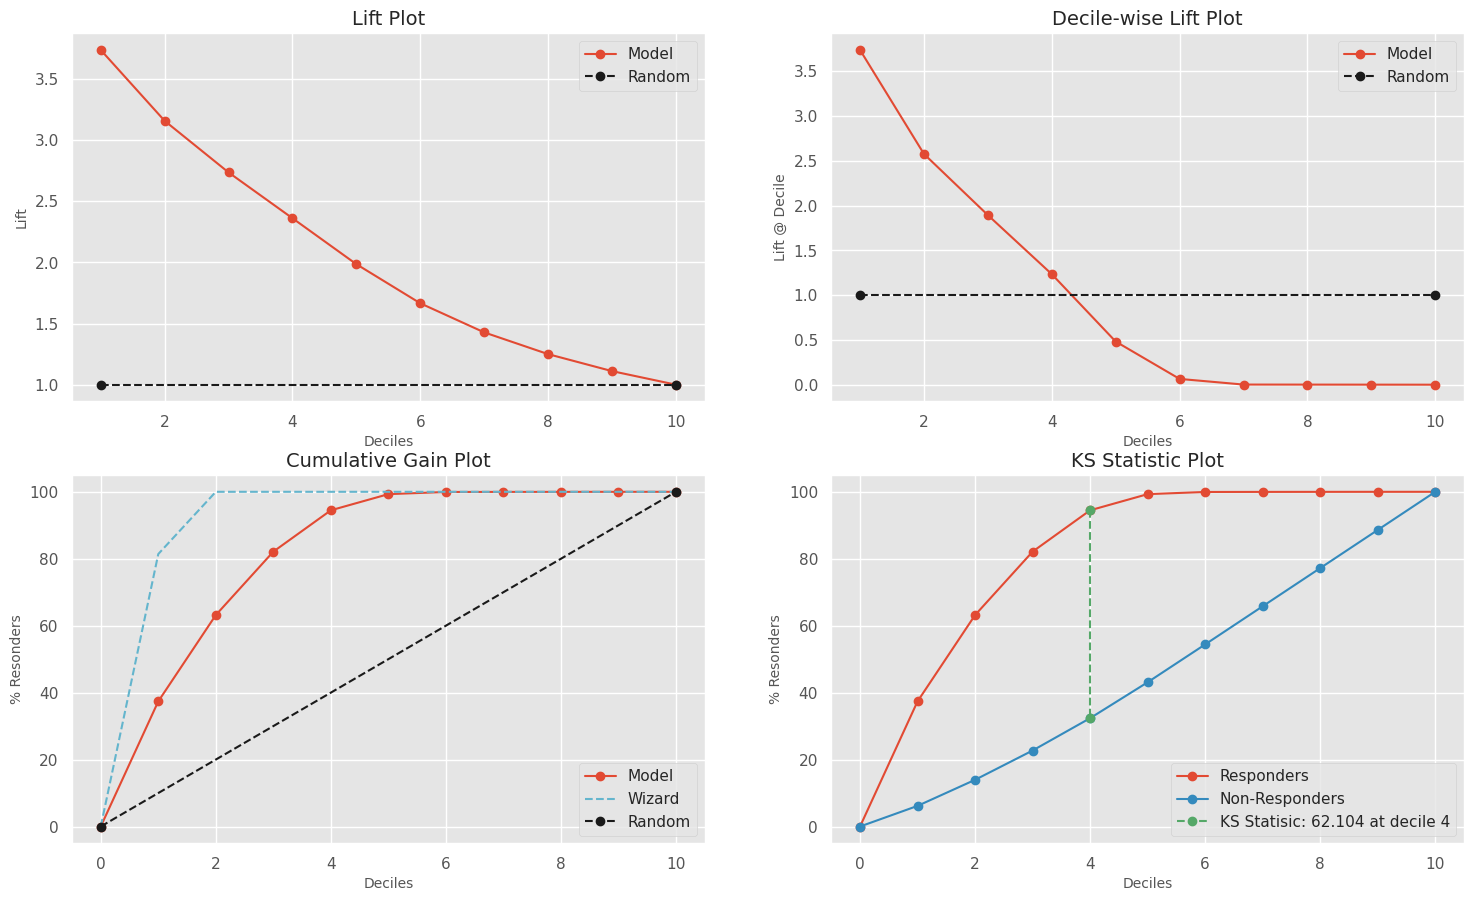

In [59]:
y_prob = opGBM.predict_proba(X_test)
kds.metrics.report(y_test, y_prob[:,1],plot_style='ggplot')

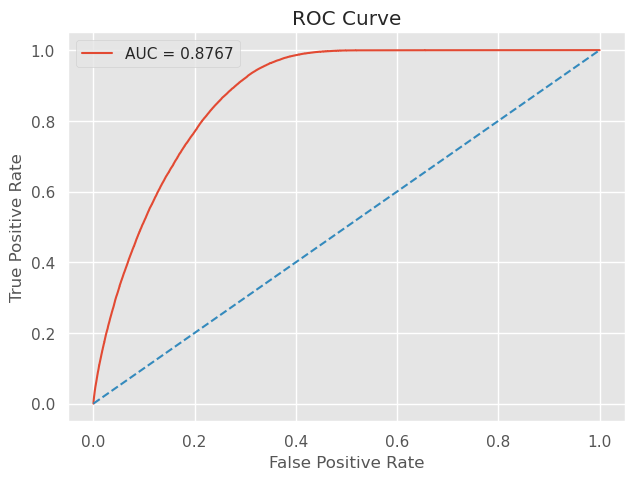

In [42]:
# Probabilidades predichas
y_prob_test = opGBM.predict_proba(X_test)[:, 1]

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# 6. Evaluación de Modelos


In [43]:
# Guardamos el mejor modelo entrenado para usarlo en la implementación
import pickle
filename = 'bestmodel.pkl'
pickle.dump(opGBM, open(filename, 'wb'))

# 7. Scoring del Modelo


In [ ]:
# Todo lo realizado en el dataset de entrenamiento del modelo lo debemos replicar en el dataset de scoring

In [61]:
data_unseen.shape

(100000, 16)

In [62]:
data_unseen.head()

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   8066424       0   37                1           28                   0   
1  10737970       0   25                1           39                   0   
2   9779423       0   23                1           46                   1   
3   1860382       1   27                1           46                   1   
4   9925271       1   43                1           30                   1   

   Vehicle_Age  Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0            1               1           38399                    26      165   
1            0               1           38467                   124      294   
2            0               0           38120                   152      103   
3            0               0           26802                   152      123   
4            1               0           29760                    26      272   

   Response  Previously_Insured_Annual_Premium  \
0         1                                  3   
1         1                                  8   
2         0                                 10   
3         0                                 18   
4         0                                 19   

   Previously_Insured_Vehicle_Age  Previously_Insured_Vehicle_Damage  \
0                               1                                  1   
1                               3                                  1   
2                               0                                  0   
3                               0                                  0   
4                               2                                  0   

   Previously_Insured_Vintage  
0                           3  
1                           9  
2                          11  
3                          20  
4                          21

In [63]:
# Una vez que tenemos todas las variables podemos scorear o puntuar los registros

# Leemos el modelo entrenado!
import pickle
filename = 'bestmodel.pkl'
mod_seg = pickle.load(open(filename, 'rb'))

In [75]:
# Predecimos sobre el set de datos de implementacion con el modelo entrenado
prob_final = mod_seg.predict_proba(data_unseen.drop(['Response'], axis=1))[:, 1]
pred_final = (prob_final >= best_threshold).astype(int)

In [65]:
pred_final.size

100000

In [76]:
# Construir DataFrame final
df_submit = pd.DataFrame({
    'Response': data_unseen['Response'],
    'Prob': prob_final,
    'Predicted': pred_final
})
# Exportamos la solucion
df_submit.to_csv('valida_scoring.csv', index=False)